In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import janitor
import yaml
import matplotlib.pyplot as plt
import palettable.matplotlib as mplpal
from matplotlib.pyplot import Line2D
import contextily as cx
from mapclassify import Quantiles
import matplotlib as mpl
from legendgram import legendgram

import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.6, style='whitegrid', palette='dark')

import warnings
warnings.filterwarnings('ignore')

from utilities.utils import get_fulldata
from utilities.graph_utils import save_mpl_fig

/mnt/d/wsl-mnt/land/venv_land/lib/python3.10/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)
/mnt/d/wsl-mnt/land/venv_land/lib/python3.10/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)


## SHRUG

In [2]:
# Get bihar stata ID from shrug
gdf_shrug_state = gpd.read_file("../data/shrug/geometries_shrug-v1.5.samosa-open-polygons-gpkg/state.gpkg")
gdf_shrug_state.info()
bihar_state_id = gdf_shrug_state.set_index("state_name").at["Bihar", "pc11_state_id"]
bihar_state_id

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   pc11_state_id  35 non-null     object  
 1   state_name     35 non-null     object  
 2   geometry       35 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 968.0+ bytes


'10'

In [3]:
# Get bihar districts polygons using above state id
gdf_bihar_district = (
    gpd.read_file("../data/shrug/geometries_shrug-v1.5.samosa-open-polygons-gpkg/district.gpkg")
    .query(f"pc11_state_id=='{bihar_state_id}'")
    .remove_columns("pc11_state_id")
    .assign(district_name=lambda df: df["district_name"].str.lower())
    .reset_index(drop=True)
)
gdf_bihar_district.info()
gdf_bihar_district.head(3)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   pc11_district_id  38 non-null     object  
 1   district_name     38 non-null     object  
 2   geometry          38 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 1.0+ KB


,pc11_district_id,district_name,geometry
0,203,pashchim champaran,"POLYGON ((84.12469 27.51105, 84.12628 27.51085..."
1,204,purba champaran,"POLYGON ((84.83041 27.01919, 84.83128 27.01916..."
2,205,sheohar,"POLYGON ((85.32738 26.65375, 85.32803 26.65304..."


In [4]:
df_bihar_district = (
    pd.read_csv("../data/shrug/shrug-secc-mord-rural-csv/secc_rural_pc11dist.csv")
    .query(f"pc11_state_id=={bihar_state_id}")
    .remove_columns("pc11_state_id")
    .reset_index(drop=True)
    .assign(own_land=lambda df_: df_["land_own_share"]* df_["secc_hh"]/10_000)
)
# https://docs.devdatalab.org/SHRUG-Metadata/Socio-Economic%20and%20Caste%20Census%20%282012%29/Tables/secc-mord-rural-metadata/
df_bihar_district.info(verbose=True)
df_bihar_district.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 104 columns):
 #    Column                          Dtype  
---   ------                          -----  
 0    pc11_district_id                int64  
 1    secc_hh                         float64
 2    sc_share                        float64
 3    ed_prim_share                   float64
 4    ed_sec_share                    float64
 5    land_own_share                  float64
 6    nco2d_cultiv_share              float64
 7    tot_p                           float64
 8    p_06                            float64
 9    m_06                            float64
 10   f_06                            float64
 11   sc_m                            float64
 12   sc_f                            float64
 13   st_m                            float64
 14   st_f                            float64
 15   unirr_land_acre_sum             float64
 16   two_crop_acre_sum               float64
 17   other_irr_acre_s

,pc11_district_id,secc_hh,sc_share,ed_prim_share,ed_sec_share,land_own_share,nco2d_cultiv_share,tot_p,p_06,m_06,...,veh_two_three_share,veh_four_share,veh_boat_share,inc_5k_plus_share,inc_10k_plus_share,_mean_p_miss,_core_p_miss,_target_weight_share,_target_group_max_weight_share,own_land
0,203,660963.517626,0.043014,0.268301,0.071908,0.344090,0.194936,3.438587e+06,400681.181834,205552.257357,...,0.157020,0.002775,0.001600,0.276808,0.057198,0.109634,0.109594,1.0,1.0,22.743114
1,204,907247.329680,0.033929,0.338830,0.074382,0.290637,0.255216,4.833617e+06,658496.741844,345359.341821,...,0.131148,0.001879,0.001544,0.269555,0.061068,0.019549,0.019440,1.0,1.0,26.367968
2,205,146979.142711,0.043439,0.270365,0.077020,0.313924,0.205248,6.229862e+05,83567.776539,43737.040586,...,0.107086,0.001403,0.000549,0.242555,0.048916,0.012749,0.012622,1.0,1.0,4.614029
3,206,713715.557370,0.034854,0.243278,0.079777,0.336703,0.177048,3.260796e+06,465242.560284,240676.485196,...,0.096160,0.001280,0.000394,0.316029,0.061678,0.020079,0.020075,1.0,1.0,24.031044
4,207,877611.206247,0.038802,0.400621,0.126481,0.299137,0.225619,4.482987e+06,609853.227718,317371.441846,...,0.109117,0.000764,0.000684,0.293595,0.059832,0.029284,0.029235,1.0,1.0,26.252555


In [5]:
df_bihar_district["total_21_above"] = (
    # =============================
    # Male
    + df_bihar_district["age_21_25_m"]
    + df_bihar_district["age_26_30_m"]
    + df_bihar_district["age_31_35_m"]
    + df_bihar_district["age_36_40_m"]
    + df_bihar_district["age_41_45_m"]
    + df_bihar_district["age_46_50_m"]
    + df_bihar_district["age_51_55_m"]
    + df_bihar_district["age_56_60_m"]
    + df_bihar_district["age_61_above_m"]
    # =============================
    # Female    
    + df_bihar_district["age_21_25_f"]
    + df_bihar_district["age_26_30_f"]
    + df_bihar_district["age_31_35_f"]
    + df_bihar_district["age_36_40_f"]
    + df_bihar_district["age_41_45_f"]
    + df_bihar_district["age_46_50_f"]
    + df_bihar_district["age_51_55_f"]
    + df_bihar_district["age_56_60_f"]
    + df_bihar_district["age_61_above_f"]    
)
df_bihar_district

,pc11_district_id,secc_hh,sc_share,ed_prim_share,ed_sec_share,land_own_share,nco2d_cultiv_share,tot_p,p_06,m_06,...,veh_four_share,veh_boat_share,inc_5k_plus_share,inc_10k_plus_share,_mean_p_miss,_core_p_miss,_target_weight_share,_target_group_max_weight_share,own_land,total_21_above
0,203,660963.517626,0.043014,0.268301,0.071908,0.344090,0.194936,3.438587e+06,400681.181834,205552.257357,...,0.002775,0.001600,0.276808,0.057198,0.109634,0.109594,1.000000,1.000000,22.743114,1.749544e+06
1,204,907247.329680,0.033929,0.338830,0.074382,0.290637,0.255216,4.833617e+06,658496.741844,345359.341821,...,0.001879,0.001544,0.269555,0.061068,0.019549,0.019440,1.000000,1.000000,26.367968,2.390002e+06
2,205,146979.142711,0.043439,0.270365,0.077020,0.313924,0.205248,6.229862e+05,83567.776539,43737.040586,...,0.001403,0.000549,0.242555,0.048916,0.012749,0.012622,1.000000,1.000000,4.614029,3.170183e+05
3,206,713715.557370,0.034854,0.243278,0.079777,0.336703,0.177048,3.260796e+06,465242.560284,240676.485196,...,0.001280,0.000394,0.316029,0.061678,0.020079,0.020075,1.000000,1.000000,24.031044,1.638230e+06
4,207,877611.206247,0.038802,0.400621,0.126481,0.299137,0.225619,4.482987e+06,609853.227718,317371.441846,...,0.000764,0.000684,0.293595,0.059832,0.029284,0.029235,1.000000,1.000000,26.252555,2.302846e+06
5,208,439957.561351,0.048882,0.268603,0.087347,0.401318,0.250050,2.161365e+06,354946.522370,183317.285953,...,0.001425,0.000260,0.227522,0.041104,0.031835,0.031832,1.000000,1.000000,17.656283,1.063640e+06
6,209,589535.890217,0.037250,0.262858,0.062436,0.305621,0.210830,2.920076e+06,465749.565971,241543.416559,...,0.000870,0.000438,0.173967,0.030747,0.069896,0.069865,1.000000,1.000000,18.017465,1.402309e+06
7,210,307616.684424,0.018894,0.220547,0.037850,0.224869,0.231751,1.553852e+06,261045.034998,132772.413144,...,0.000705,0.000691,0.180700,0.024155,0.160011,0.159961,1.000000,1.000000,6.917344,7.147061e+05
8,211,589373.491756,0.036776,0.216379,0.058481,0.302027,0.153065,2.936607e+06,457792.417998,235757.422783,...,0.001277,0.001083,0.222187,0.036368,0.078137,0.078006,1.000000,1.000000,17.800686,1.413285e+06
9,212,564563.038399,0.023146,0.277760,0.070946,0.253934,0.174901,2.800926e+06,460199.036253,235175.028923,...,0.001220,0.000353,0.230229,0.041680,0.106140,0.106100,1.000000,1.000000,14.336150,1.333509e+06


In [6]:
gdf_bihar_district = (
    gdf_bihar_district
    .astype({"pc11_district_id": int})
    .merge(df_bihar_district, on="pc11_district_id", how="inner", validate="1:1")
)
gdf_bihar_district.head(3)

,pc11_district_id,district_name,geometry,secc_hh,sc_share,ed_prim_share,ed_sec_share,land_own_share,nco2d_cultiv_share,tot_p,...,veh_four_share,veh_boat_share,inc_5k_plus_share,inc_10k_plus_share,_mean_p_miss,_core_p_miss,_target_weight_share,_target_group_max_weight_share,own_land,total_21_above
0,203,pashchim champaran,"POLYGON ((84.12469 27.51105, 84.12628 27.51085...",660963.517626,0.043014,0.268301,0.071908,0.344090,0.194936,3.438587e+06,...,0.002775,0.001600,0.276808,0.057198,0.109634,0.109594,1.0,1.0,22.743114,1.749544e+06
1,204,purba champaran,"POLYGON ((84.83041 27.01919, 84.83128 27.01916...",907247.329680,0.033929,0.338830,0.074382,0.290637,0.255216,4.833617e+06,...,0.001879,0.001544,0.269555,0.061068,0.019549,0.019440,1.0,1.0,26.367968,2.390002e+06
2,205,sheohar,"POLYGON ((85.32738 26.65375, 85.32803 26.65304...",146979.142711,0.043439,0.270365,0.077020,0.313924,0.205248,6.229862e+05,...,0.001403,0.000549,0.242555,0.048916,0.012749,0.012622,1.0,1.0,4.614029,3.170183e+05


## Bihar LR

### Get the dictionary of clean names

In [7]:
fp = "../shrug-scratch/bihar_lr_clean_district_names.yaml"
with open(fp, 'r') as file:
       district_map_hand = yaml.safe_load(file)
district_map_hand

{'araval': 'arwal',
 'begusaray': 'begusarai',
 'bucksre': 'buxar',
 'camor': 'kaimur (bhabua)',
 'jahanabad': 'jehanabad',
 'khagriya': 'khagaria',
 'kishenganj': 'kishanganj',
 'muzfarpur': 'muzaffarpur',
 'navada': 'nawada',
 'purniyaaayaaon': 'purnia',
 'purvi champaran': 'purba champaran',
 'shekhpura': 'sheikhpura',
 'shivahar': 'sheohar',
 'sitamadhi': 'sitamarhi',
 'sivan': 'siwan'}

In [8]:
df_districts = (
    pd.read_csv("../shrug-scratch/districts.csv")
    .assign(district_name=lambda df_: df_["eng"].map(district_map_hand))
    .assign(district_name=lambda df_: np.where(df_["district_name"].isna(), df_["eng"], df_["district_name"]))
    .remove_columns("eng")
)
df_districts

,district,district_name
0,वैशाली,vaishali
1,गया,gaya
2,रोहतास,rohtas
3,समस्तीपुर,samastipur
4,मुंगेर,munger
5,बक्सर,buxar
6,अररिया,araria
7,बांका,banka
8,सुपौल,supaul
9,शिवहर,sheohar


### Get LR and merge to polygons

In [9]:
df_lr = (
    get_fulldata(**{'usecols': ["account_no", "district", "6", "7", "8"]})
    .drop_duplicates("account_no")
    .rename_columns(new_column_names={"6": "acres", "7": "decimals", "8": "hectare"})
    .assign(tt_area_acre=lambda df: df["acres"]+df["decimals"]/100)
    .query("tt_area_acre>0")
    .merge(df_districts, how="left", on="district", validate="m:1")
)
print(df_lr.shape)
df_lr.head()

(11601882, 7)


,district,account_no,acres,decimals,hectare,tt_area_acre,district_name
0,अररिया,701010001000008,8.0,52.5,0.0,8.525,araria
1,अररिया,701010001000003,0.0,56.0,0.0,0.560,araria
2,अररिया,701010001000027,0.0,63.0,0.0,0.630,araria
3,अररिया,701010001000039,0.0,22.0,0.0,0.220,araria
4,अररिया,701010001000006,0.0,56.5,0.0,0.565,araria


In [10]:
gdf_lr_accounts = (
    gpd.read_file("../data/shrug/geometries_shrug-v1.5.samosa-open-polygons-gpkg/district.gpkg")
    .query(f"pc11_state_id=='{bihar_state_id}'")
    .assign(district_name=lambda df: df["district_name"].str.lower())
    .astype({"pc11_district_id": int})
    .merge(df_lr.groupby("district_name").size().reset_index(), on="district_name", how="inner", validate="1:m")
    .rename_column(0, "count")
    .merge(df_bihar_district, on="pc11_district_id", how="left", validate="1:1")
    .assign(count=lambda df_: df_["count"]/10_000)
    # Get x - y coords
    .assign(x=lambda gdf_: gdf_["geometry"].centroid.x)
    .assign(y=lambda gdf_: gdf_["geometry"].centroid.y)
)
gdf_lr_accounts

,pc11_state_id,pc11_district_id,district_name,geometry,count,secc_hh,sc_share,ed_prim_share,ed_sec_share,land_own_share,...,inc_5k_plus_share,inc_10k_plus_share,_mean_p_miss,_core_p_miss,_target_weight_share,_target_group_max_weight_share,own_land,total_21_above,x,y
0,10,203,pashchim champaran,"POLYGON ((84.12469 27.51105, 84.12628 27.51085...",28.2818,660963.517626,0.043014,0.268301,0.071908,0.344090,...,0.276808,0.057198,0.109634,0.109594,1.000000,1.000000,22.743114,1.749544e+06,84.337160,27.080435
1,10,204,purba champaran,"POLYGON ((84.83041 27.01919, 84.83128 27.01916...",7.1882,907247.329680,0.033929,0.338830,0.074382,0.290637,...,0.269555,0.061068,0.019549,0.019440,1.000000,1.000000,26.367968,2.390002e+06,84.919460,26.618224
2,10,205,sheohar,"POLYGON ((85.32738 26.65375, 85.32803 26.65304...",10.8200,146979.142711,0.043439,0.270365,0.077020,0.313924,...,0.242555,0.048916,0.012749,0.012622,1.000000,1.000000,4.614029,3.170183e+05,85.302813,26.497514
3,10,206,sitamarhi,"POLYGON ((85.66200 26.84586, 85.66625 26.84437...",48.0475,713715.557370,0.034854,0.243278,0.079777,0.336703,...,0.316029,0.061678,0.020079,0.020075,1.000000,1.000000,24.031044,1.638230e+06,85.552496,26.586775
4,10,207,madhubani,"POLYGON ((86.06059 26.65650, 86.06645 26.65505...",47.5394,877611.206247,0.038802,0.400621,0.126481,0.299137,...,0.293595,0.059832,0.029284,0.029235,1.000000,1.000000,26.252555,2.302846e+06,86.219688,26.402895
5,10,208,supaul,"POLYGON ((87.05293 26.55341, 87.05334 26.55334...",13.3508,439957.561351,0.048882,0.268603,0.087347,0.401318,...,0.227522,0.041104,0.031835,0.031832,1.000000,1.000000,17.656283,1.063640e+06,86.806259,26.242223
6,10,209,araria,"POLYGON ((87.06975 26.56275, 87.06950 26.55288...",49.3892,589535.890217,0.037250,0.262858,0.062436,0.305621,...,0.173967,0.030747,0.069896,0.069865,1.000000,1.000000,18.017465,1.402309e+06,87.362129,26.198134
7,10,210,kishanganj,"MULTIPOLYGON (((87.84553 25.98449, 87.84566 25...",30.9966,307616.684424,0.018894,0.220547,0.037850,0.224869,...,0.180700,0.024155,0.160011,0.159961,1.000000,1.000000,6.917344,7.147061e+05,87.934101,26.293826
8,10,211,purnia,"POLYGON ((87.71802 26.11298, 87.71835 26.11297...",85.8707,589373.491756,0.036776,0.216379,0.058481,0.302027,...,0.222187,0.036368,0.078137,0.078006,1.000000,1.000000,17.800686,1.413285e+06,87.403819,25.815148
9,10,212,katihar,"POLYGON ((87.82502 25.88259, 87.82553 25.88247...",26.3378,564563.038399,0.023146,0.277760,0.070946,0.253934,...,0.230229,0.041680,0.106140,0.106100,1.000000,1.000000,14.336150,1.333509e+06,87.641961,25.545291


### Correlate land ownership from LR and census

In [11]:
gdf_lr_accounts["count"].corr(gdf_lr_accounts["own_land"])

0.2826407015688018

In [12]:
gdf_lr_accounts["count"].corr(gdf_lr_accounts["total_21_above"])

0.3704070201758315

In [13]:
gdf_lr_accounts["own_land"].corr(gdf_lr_accounts["total_21_above"])

0.8763262462969696

In [14]:
# gdf_lr_accounts[["district_name", "count", "own_land"]].sort_values("count")

In [15]:
outliers = ["saharsa", "siwan", "saran", "purba champaran", "samastipur", "purnia"]
# outliers = ["siwan", "saran", "purba champaran", "samastipur", "purnia"]

# outliers = ["saharsa", "siwan", "saran", "purba champaran", "samastipur",]

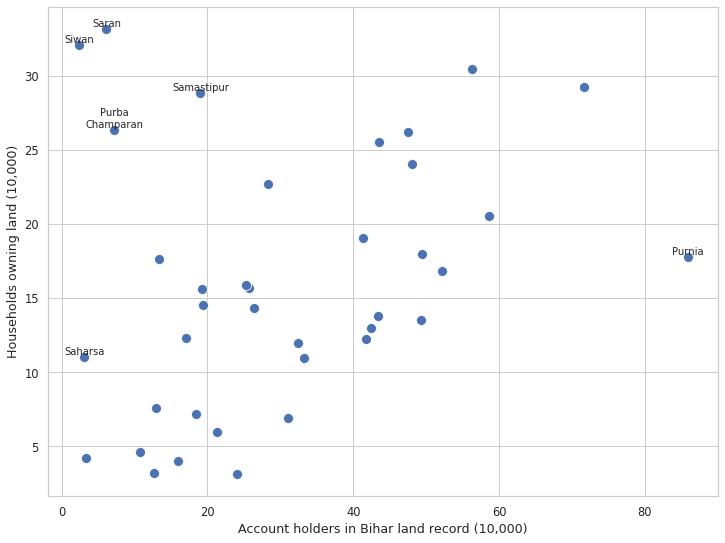

In [16]:
_scale = 3
fig, ax = plt.subplots(figsize=(4*_scale,3*_scale))

sns.scatterplot(
    data=gdf_lr_accounts, 
    x='count', 
    y='own_land', 
    s=100,
    ax=ax
)
for ix, row in gdf_lr_accounts.iterrows():
    
    district = row["district_name"]
    if district in outliers:
        x = row["count"]
        y = row["own_land"]        
        plt.text(x, y, s="\n".join(district.title().split(" ")), va="bottom", ha="center")
        
plt.xlabel("Account holders in Bihar land record (10,000)")
plt.ylabel("Households owning land (10,000)")
save_mpl_fig("../figures/corr-district-hh-own-land-accountholders")

In [17]:
_gdf = gdf_lr_accounts.query("district_name not in @outliers")
_gdf.head(3)

,pc11_state_id,pc11_district_id,district_name,geometry,count,secc_hh,sc_share,ed_prim_share,ed_sec_share,land_own_share,...,inc_5k_plus_share,inc_10k_plus_share,_mean_p_miss,_core_p_miss,_target_weight_share,_target_group_max_weight_share,own_land,total_21_above,x,y
0,10,203,pashchim champaran,"POLYGON ((84.12469 27.51105, 84.12628 27.51085...",28.2818,660963.517626,0.043014,0.268301,0.071908,0.344090,...,0.276808,0.057198,0.109634,0.109594,1.0,1.0,22.743114,1.749544e+06,84.337160,27.080435
2,10,205,sheohar,"POLYGON ((85.32738 26.65375, 85.32803 26.65304...",10.8200,146979.142711,0.043439,0.270365,0.077020,0.313924,...,0.242555,0.048916,0.012749,0.012622,1.0,1.0,4.614029,3.170183e+05,85.302813,26.497514
3,10,206,sitamarhi,"POLYGON ((85.66200 26.84586, 85.66625 26.84437...",48.0475,713715.557370,0.034854,0.243278,0.079777,0.336703,...,0.316029,0.061678,0.020079,0.020075,1.0,1.0,24.031044,1.638230e+06,85.552496,26.586775


In [18]:
_gdf["count"].corr(_gdf["own_land"])

0.7364075871448109

In [19]:
_gdf["count"].corr(_gdf["total_21_above"])

0.7267805091334126

In [20]:
_gdf["own_land"].corr(_gdf["total_21_above"])

0.8771952921235501

### Plot number of accounts

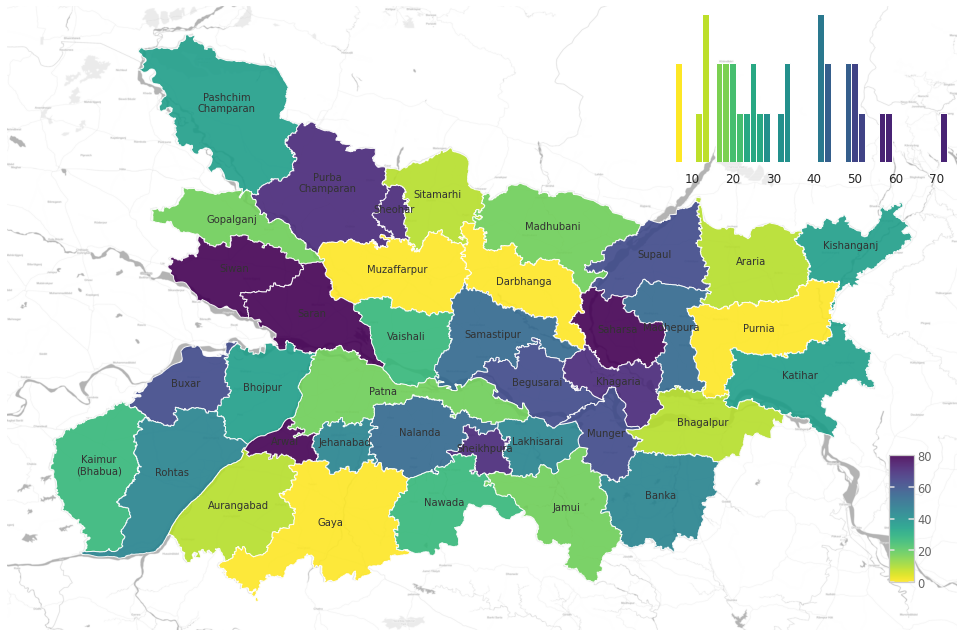

In [21]:
_scale = 4
fig, ax = plt.subplots(figsize=(4*_scale,3*_scale))

x = "count"
cmap="viridis_r"

# =======================================================================
# Plot map
gdf_lr_accounts.plot(
    column=x, 
    scheme="Quantiles", 
    k=10,
    alpha=.9,
    ax=ax
)

# =========================================================
# Annotate districts
for ix, row in gdf_lr_accounts.iterrows():
    distrct = "\n".join(row["district_name"].title().split(" "))
    x = row["x"]
    y = row["y"]
    ax.annotate(distrct, xy=(x, y), xytext=(x, y), ha="center", size=10, color=".2")


# =======================================================================
# Prep assets for cbar
# xs = gdf_lr_accounts[x]
markers = [0, 20, 40, 60, 80]
norm = mpl.colors.Normalize(vmin=0, vmax=markers[-1])

# =======================================================================
# Plot cbar
with sns.axes_style("whitegrid"):
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      orientation='vertical',
                      aspect=5, # Ratio of long to short dimensions.
                      alpha=0.9,
                      pad=0.01,ticks=markers,
                      anchor=(-.55, .22),
                      shrink=.15
                     )

# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=".4")
# # # # remove ticks
cb.ax.tick_params(size=0)
cb.ax.tick_params(length=0)

for bound in markers[:-1]:
    cb.ax.plot([0, .2], [bound]*2, '.9', lw=1.5,)
    cb.ax.plot([.8, 1], [bound]*2, '.9', lw=1.5,)

# =========================================================
# Axis
plt.axis("off")
plt.tight_layout()

# =========================================================
# Base map
basemap_opts = dict(
    crs=gdf_lr_accounts.crs,
    source=cx.providers.Stamen.Toner,
    zoom=10,
    attribution="",
    alpha=0.3,
    zorder=0,
    )
cx.add_basemap(**basemap_opts, ax=ax)

# =========================================================
# Legend
xs = gdf_lr_accounts["count"]
with sns.axes_style("white"):
    legendgram(
        plt.gcf(), # grab the figure, we need it
        ax, # the axis to add the legend
        xs, # the attribute to map
        np.percentile(xs, np.arange(10,110,10)), # the␣ breaks to induce color differences on
        mplpal.Viridis_10_r, # the palette to use
        clip=(5,75), # bounds to clip the view of the histogram
        legend_size=(.3,.25), # the size of the subplot, in fractions of␣ the original axis
        loc= 'upper right', # the location on the axis
    )
    
save_mpl_fig("../figures/map-bihar-districts-accountholders")